# The Analysis of Dynamic SBM: by-production technologies for cities in Taiwan with undesirable output for each city

## 1. Data

In [1]:
from gurobipy import *
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def Read_data(datasetPath):
    Carry_Labor = pd.read_excel(datasetPath, sheet_name='Labor', index_col=0) # carry-over
    Input_Tax = pd.read_excel(datasetPath, sheet_name='Tax', index_col=0) # non-pollution-causing input
    Input_Population = pd.read_excel(datasetPath, sheet_name='Population', index_col=0) # pollution-causing
    Output_Trash = pd.read_excel(datasetPath, sheet_name='Trash', index_col=0) # bad output
    Output_GDP = pd.read_excel(datasetPath, sheet_name='GDP', index_col=0) # good output
    K = list(Carry_Labor.index)
    Year = [2014, 2015, 2016, 2017, 2018, 2019]
    Area = {'北部': [0, 1, 2, 6, 7, 17, 18], 
            '中部': [3, 8, 9, 10, 11],
            '南部': [4, 5, 12, 13, 19],
            '東部': [14, 15], '離島': [16, 20]}
    return Carry_Labor.values.tolist(), Input_Tax.values.tolist(), Input_Population.values.tolist(), Output_Trash.values.tolist(), Output_GDP.values.tolist(), K, Year, Area


In [2]:
Carry_Labor, Input_Tax, Input_Population, Output_Trash, Output_GDP, K, Year, Area = Read_data('./data.xlsx')

## 2. By-Production + Dynamic SBM

$\theta^*_{r} = \min \sum_{t \in T} w_t(\tau - \frac{1}{|I^N| + |I^P|} (\sum_{i \in I^N}\frac{s^{N-}_{it}}{X^N_{rit}} + \frac{1}{2}(\sum_{i \in I^P}\frac{s^{GP-}_{it}}{X^P_{rit}} + \sum_{i \in I^P}\frac{s^{BP-}_{it}}{X^P_{rit}})))$

s.t. $\sum_{k \in K}\lambda^t_kY_{kjt} - s^{N+}_{jt} = \tau Y_{rjt}, \forall j \in J^N, \forall t \in T$<br>
$\sum_{k \in K}\lambda^t_kX^N_{kit} + s^{N-}_{it} = \tau X^N_{rit}, \forall i \in I^N, \forall t \in T$<br>
$\sum_{k \in K}\lambda^t_kX^P_{kit} + s^{GP-}_{it} = \tau X^P_{rit}, \forall i \in I^P, \forall t \in T$<br>
$\sum_{k \in K}\mu^t_kB_{kjt} - s^{P+}_{jt} = \tau B_{rjt}, \forall j \in J^P, \forall t \in T$<br>
$\sum_{k \in K}\mu^t_kX^P_{kit} + s^{BP-}_{it} = \tau X^P_{rit}, \forall i \in I^P, \forall t \in T$<br>
$\sum_{k \in K}\lambda^t_kZ^{free}_{kit} + s^{free}_{it} = \tau Z^{free}_{rit}, \forall i \in I^C, \forall t \in T$<br>
$\sum_{k \in K} Z^{free}_{kit}\lambda^t_k = \sum_{k \in K} Z^{free}_{kit}\lambda^{t+1}_k, \forall t = 1, ..., T-1$<br>

$\tau + \frac{1}{|J^N| + |J^P|}(\sum_{j \in J^N}\frac{s^{N+}_{jt}}{Y_{rjt}} + \sum_{j \in J^P}\frac{s^{P+}_{jt}}{B_{rjt}}) = 1, \forall t \in T$

$\sum_{k \in K} \lambda^t_k = 1, \forall t \in T$<br>
$\sum_{k \in K} \mu^t_k = 1, \forall t \in T$

$\lambda^t_k \geq 0, \forall k \in K$<br>
$\mu^t_k \geq 0, \forall k \in K$<br>
$s^{N-}_{it} \geq 0, \forall i \in I^N$<br>
$s^{N+}_{jt} \geq 0, \forall i \in J^N$<br>
$s^{GP-}_{it} \geq 0, \forall i \in I^P$<br>
$s^{P+}_{jt} \geq 0, \forall j \in J^P$<br>
$s^{BP-}_{it} \geq 0, \forall i \in I^P$<br>
$s^{free}_{it} \text{urs.} \forall i \in I^C$<br>
$\tau \geq \epsilon > 0$


In [3]:
def DynamicSBM_Byproduction(Carry_Labor, Input_Tax, Input_Population, Output_Trash, Output_GDP, K, Year):
    T = len(Year)
    Type = ['bp_VRS_free', 'bp_VRS_fix', 'bp_CRS_free', 'bp_CRS_fix']
    C = {'Labor'} # carry over
    M = {'GDP'} # desirable outputs
    J = {'Trash'} # undesirable outputs
    N = {'Tax'} # sub non-pollution-causing inputs
    P = {'Population'} # sub pollution-causing inputs
    
    X = {} #Input
    Z = {} # free carry over
    for k in range(len(K)):
        Z[K[k],'Labor'] = Carry_Labor[k]
        X[K[k],'Population'] = Input_Population[k]
        X[K[k],'Tax'] = Input_Tax[k]
    Y = {} # Good Ouput
    B = {}  # Bad Output
    for k in range(len(K)):
        B[K[k],'Trash'] = Output_Trash[k]
        Y[K[k],'GDP'] = Output_GDP[k]   
        
    BP_D_SBM = {}
    bp_year = {}

    for i in range(len(Type)):
        all_temp = {}
        part_temp = {}
        for firm in K:
            model = Model('byProductDynamicSBM')
            model.setParam('OutputFlag', 0)

            Lambda, Mu = {}, {}
            a = model.addVar(vtype = "C", name = "a",lb=0.0000001)
            S_free, S_Npos, S_Nmin, S_GPmin, S_Ppos, S_BPmin = {}, {}, {}, {}, {}, {}
            for t in range(T):
                for k in K:
                    Lambda[k, t] = model.addVar(vtype = "C", name = "Lambda(%s)(%s)"%(k, t),lb=0)
                    Mu[k, t] = model.addVar(vtype = "C", name = "Mu(%s)(%s)"%(k, t),lb=0)
                for m in M:
                    S_Npos[m, t] = model.addVar(vtype = "C", name = "S_N+(%s)(%s)"%(m, t),lb=0)
                for j in J:
                    S_Ppos[j, t] = model.addVar(vtype = "C", name = "S_P+(%s)(%s)"%(j, t),lb=0)
                for n in N:
                    S_Nmin[n, t] = model.addVar(vtype = "C", name = "S_N-(%s)(%s)"%(n, t),lb=0)
                for c in C:
                    S_free[c, t] = model.addVar(vtype = "C", name = "S_free(%s)(%s)"%(c, t),lb=-GRB.INFINITY)
                for p in P:
                    S_GPmin[p, t] = model.addVar(vtype = "C", name = "S_GP-(%s)(%s)"%(p, t),lb=0)
                    S_BPmin[p, t] = model.addVar(vtype = "C", name = "S_BP-(%s)(%s)"%(p, t),lb=0)
            model.update()
            model.setObjective(quicksum(a - (quicksum(S_Nmin[n, t]/X[firm, n][t] for n in N) \
                + (quicksum(S_GPmin[p, t]/X[firm, p][t] for p in P) + quicksum(S_BPmin[p, t]/X[firm, p][t] for p in P)) / 2) \
                / (len(N) + len(P)) for t in range(T)) / T, GRB.MINIMIZE)
            for t in range(T):
                model.addConstr(1 == a + (quicksum(S_Npos[m, t]/Y[firm, m][t] for m in M) + quicksum(S_Ppos[j, t]/B[firm, j][t] for j in J)) / (len(M) + len(J)))
                if(i < 2):
                    model.addConstr(quicksum(Lambda[k, t] for k in K) == 1)
                    model.addConstr(quicksum(Mu[k, t] for k in K) == 1)

                for m in M:
                    model.addConstr(quicksum(Lambda[k, t] * Y[k, m][t] for k in K) - S_Npos[m, t] == a * Y[firm, m][t])
                for j in J:
                    model.addConstr(quicksum(Mu[k, t] * B[k, j][t] for k in K) - S_Ppos[j, t] == a * B[firm, j][t])
                for n in N:
                    model.addConstr(quicksum(Lambda[k, t] * X[k, n][t] for k in K) + S_Nmin[n, t] == a * X[firm, n][t])
                for p in P:
                    model.addConstr(quicksum(Lambda[k, t] * X[k, p][t] for k in K) + S_GPmin[p, t] == a * X[firm, p][t])
                    model.addConstr(quicksum(Mu[k, t] * X[k, p][t] for k in K) + S_BPmin[p, t] == a * X[firm, p][t])
            for t in range(T-1):
                for c in C:
                    if(i % 2 == 0):
                        model.addConstr(quicksum(Lambda[k, t] * Z[k, c][t] for k in K) + S_free[c, t] == a * Z[firm, c][t])
                    else:
                        model.addConstr(quicksum(Lambda[k, t] * Z[k, c][t] for k in K) == a * Z[firm, c][t]) # fix
                    model.addConstr(quicksum(Lambda[k, t] * Z[k, c][t] for k in K) == quicksum(Lambda[k, t + 1] * Z[k, c][t] for k in K))
            model.optimize()
            all_temp[firm] = model.objVal

            temp = []
            for t in range(T):
                temp.append((LinExpr.getValue(a - (LinExpr.getValue(quicksum(S_Nmin[n, t]/X[firm, n][t] for n in N)) 
                                + (LinExpr.getValue((quicksum(S_GPmin[p, t]/X[firm, p][t] for p in P)))
                                + LinExpr.getValue(quicksum(S_BPmin[p, t]/X[firm, p][t] for p in P)))/2) / (len(N) + len(P)))))
            part_temp[firm] = temp
        BP_D_SBM[Type[i]] = all_temp
        bp_year[Type[i]] = part_temp
    return BP_D_SBM, bp_year

In [4]:
BP_D_SBM, bp_year = DynamicSBM_Byproduction(Carry_Labor, Input_Tax, Input_Population, Output_Trash, Output_GDP, K, Year)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-13


### -- Area 

In [5]:
def DynamicSBM_Byproduction_Area(Carry_Labor, Input_Tax, Input_Population, Output_Trash, Output_GDP, Year, Area):
    T = len(Year)
    Type = ['bp_VRS_free', 'bp_VRS_fix', 'bp_CRS_free', 'bp_CRS_fix']
    C = {'Labor'} # carry over
    M = {'GDP'} # desirable outputs
    J = {'Trash'} # undesirable outputs
    N = {'Tax'} # sub non-pollution-causing inputs
    P = {'Population'} # sub pollution-causing inputs
    
    X = {} #Input
    Z = {} # free carry over
    for k in Area:
        temp = [Carry_Labor[city] for city in Area[k]]
        Z[k, 'Labor'] = [sum(sub_list) / len(sub_list) for sub_list in zip(*temp)]
        temp = [Input_Population[city] for city in Area[k]]
        X[k, 'Population'] = [sum(sub_list) / len(sub_list) for sub_list in zip(*temp)]
        temp = [Input_Tax[city] for city in Area[k]]
        X[k, 'Tax'] = [sum(sub_list) / len(sub_list) for sub_list in zip(*temp)]
    Y = {} # Good Ouput
    B = {}  # Bad Output
    for k in Area:
        temp = [Output_Trash[city] for city in Area[k]]
        B[k,'Trash'] = [sum(sub_list) / len(sub_list) for sub_list in zip(*temp)]
        temp = [Output_GDP[city] for city in Area[k]]
        Y[k,'GDP'] = [sum(sub_list) / len(sub_list) for sub_list in zip(*temp)]
        
    BP_D_SBM_Area = {}
    bp_year_area = {}

    for i in range(len(Type)):
        all_temp = {}
        part_temp = {}
        for firm in Area:
            model = Model('byProductDynamicSBMArea')
            model.setParam('OutputFlag', 0)

            Lambda, Mu = {}, {}
            a = model.addVar(vtype = "C", name = "a",lb=0.0000001)
            S_free, S_Npos, S_Nmin, S_GPmin, S_Ppos, S_BPmin = {}, {}, {}, {}, {}, {}
            for t in range(T):
                for k in Area:
                    Lambda[k, t] = model.addVar(vtype = "C", name = "Lambda(%s)(%s)"%(k, t),lb=0)
                    Mu[k, t] = model.addVar(vtype = "C", name = "Mu(%s)(%s)"%(k, t),lb=0)
                for m in M:
                    S_Npos[m, t] = model.addVar(vtype = "C", name = "S_N+(%s)(%s)"%(m, t),lb=0)
                for j in J:
                    S_Ppos[j, t] = model.addVar(vtype = "C", name = "S_P+(%s)(%s)"%(j, t),lb=0)
                for n in N:
                    S_Nmin[n, t] = model.addVar(vtype = "C", name = "S_N-(%s)(%s)"%(n, t),lb=0)
                for c in C:
                    S_free[c, t] = model.addVar(vtype = "C", name = "S_free(%s)(%s)"%(c, t),lb=-GRB.INFINITY)
                for p in P:
                    S_GPmin[p, t] = model.addVar(vtype = "C", name = "S_GP-(%s)(%s)"%(p, t),lb=0)
                    S_BPmin[p, t] = model.addVar(vtype = "C", name = "S_BP-(%s)(%s)"%(p, t),lb=0)
            model.update()
            model.setObjective(quicksum(a - (quicksum(S_Nmin[n, t]/X[firm, n][t] for n in N) \
                + (quicksum(S_GPmin[p, t]/X[firm, p][t] for p in P) + quicksum(S_BPmin[p, t]/X[firm, p][t] for p in P)) / 2) \
                / (len(N) + len(P)) for t in range(T)) / T, GRB.MINIMIZE)
            for t in range(T):
                model.addConstr(1 == a + (quicksum(S_Npos[m, t]/Y[firm, m][t] for m in M) + quicksum(S_Ppos[j, t]/B[firm, j][t] for j in J)) / (len(M) + len(J)))
                if(i < 2):
                    model.addConstr(quicksum(Lambda[k, t] for k in Area) == 1)
                    model.addConstr(quicksum(Mu[k, t] for k in Area) == 1)

                for m in M:
                    model.addConstr(quicksum(Lambda[k, t] * Y[k, m][t] for k in Area) - S_Npos[m, t] == a * Y[firm, m][t])
                for j in J:
                    model.addConstr(quicksum(Mu[k, t] * B[k, j][t] for k in Area) - S_Ppos[j, t] == a * B[firm, j][t])
                for n in N:
                    model.addConstr(quicksum(Lambda[k, t] * X[k, n][t] for k in Area) + S_Nmin[n, t] == a * X[firm, n][t])
                for p in P:
                    model.addConstr(quicksum(Lambda[k, t] * X[k, p][t] for k in Area) + S_GPmin[p, t] == a * X[firm, p][t])
                    model.addConstr(quicksum(Mu[k, t] * X[k, p][t] for k in Area) + S_BPmin[p, t] == a * X[firm, p][t])
            for t in range(T-1):
                for c in C:
                    if(i % 2 == 0):
                        model.addConstr(quicksum(Lambda[k, t] * Z[k, c][t] for k in Area) + S_free[c, t] == a * Z[firm, c][t])
                    else:
                        model.addConstr(quicksum(Lambda[k, t] * Z[k, c][t] for k in Area) == a * Z[firm, c][t]) # fix
                    model.addConstr(quicksum(Lambda[k, t] * Z[k, c][t] for k in Area) == quicksum(Lambda[k, t + 1] * Z[k, c][t] for k in Area))
            model.optimize()
            all_temp[firm] = model.objVal

            temp = []
            for t in range(T):
                temp.append((LinExpr.getValue(a - (LinExpr.getValue(quicksum(S_Nmin[n, t]/X[firm, n][t] for n in N)) 
                                + (LinExpr.getValue((quicksum(S_GPmin[p, t]/X[firm, p][t] for p in P)))
                                + LinExpr.getValue(quicksum(S_BPmin[p, t]/X[firm, p][t] for p in P)))/2) / (len(N) + len(P)))))
            part_temp[firm] = temp
        BP_D_SBM_Area[Type[i]] = all_temp
        bp_year_area[Type[i]] = part_temp
    return BP_D_SBM_Area, bp_year_area

In [6]:
BP_D_SBM_Area, bp_year_area = DynamicSBM_Byproduction_Area(Carry_Labor, Input_Tax, Input_Population, Output_Trash, Output_GDP, Year, Area)

## 3. Dynamic SBM (Free-disposable)

$\theta^*_{r} = \min \sum_{t \in T}w^t(\tau - \frac{1}{|I^N|} \sum_{i \in I^N}\frac{s^{tN-}_{i}}{X^{tN}_{ri}})$

s.t. $\sum_{k \in K}\lambda^t_kY^t_{kj} - s^{tN+}_{j} = \tau Y^t_{rj}, \forall j \in J^N, \forall t \in T$<br>
$\sum_{k \in K}\lambda^t_kX^{tN}_{ki} + s^{tN-}_{i} = \tau X^{tN}_{ri}, \forall i \in I^N, \forall t \in T$<br>
$\sum_{k \in K}\lambda^t_kz^{(t,t+1)}_{kl_{free}} + s^{tC}_{l_{free}} = \tau z^{(t,t+1)}_{kl_{free}}, \forall l \in L_{free}, \forall t \in T$<br>
$\sum_{k \in K} \lambda^t_kz^{(t,t+1)}_{kl_{free}} = \sum_{k \in K} \lambda^{t+1}_kz^{(t,t+1)}_{kl_{free}}, t \in T-1$<br>

$\tau + \frac{1}{|J^N|}\sum_{j \in J^N}\frac{s^{tN+}_{j}}{Y^t_{rj}} = 1, \forall t \in T$


$\lambda^t_k \geq 0, \forall k \in K \ \forall t \in T$<br>
$s^{tN-}_{i} \geq 0, \forall i \in I^N \ \forall t \in T$<br>
$s^{tN+}_{j} \geq 0, \forall i \in J^N \ \forall t \in T$<br>
$s_{l_{free}}^{tC} \text{urs.} \ \forall l_{free} \in L_{free},\ t \in T-1$ <br>
$\tau \geq \epsilon > 0$

In [7]:
def DynamicSBM(Carry_Labor, Input_Tax, Input_Population, Output_Trash, Output_GDP, K, Year):
    T = len(Year)
    Type = ['VRS_free', 'VRS_fix', 'CRS_free', 'CRS_fix']

    C = {'Labor'} # carry over
    M = {'GDP'} # Outputs
    N = {'Tax', 'Population', 'Trash'} # Inputs

    X = {} #Input
    Z = {} # free carry over
    for k in range(len(K)):
        Z[K[k],'Labor'] = Carry_Labor[k]
        X[K[k],'Population'] = Input_Population[k]
        X[K[k],'Tax'] = Input_Tax[k]
        X[K[k],'Trash'] = Output_Trash[k]
    Y = {} # Ouput
    for k in range(len(K)):
        Y[K[k],'GDP'] = Output_GDP[k]  
        
    D_SBM = {}
    no_year = {}

    for i in range(len(Type)):
        all_temp = {}
        part_temp = {}
        for firm in K:
            model = Model('DynamicSBM')
            model.setParam('OutputFlag', 0)

            Lambda = {}
            a = model.addVar(vtype = "C", name = "a", lb=0.0000001)
            S_free, S_Npos, S_Nmin = {}, {}, {}
            for t in range(T):
                for k in K:
                    Lambda[k, t] = model.addVar(vtype = "C", name = "Lambda(%s)(%s)"%(k, t),lb=0)
                for m in M:
                    S_Npos[m, t] = model.addVar(vtype = "C", name = "S_N+(%s)(%s)"%(m, t),lb=0)
                for n in N:
                    S_Nmin[n, t] = model.addVar(vtype = "C", name = "S_N-(%s)(%s)"%(n, t),lb=0)
                for c in C:
                    S_free[c, t] = model.addVar(vtype = "C", name = "S_free(%s)(%s)"%(c, t),lb=-GRB.INFINITY)
            model.update()
            model.setObjective(quicksum(a - quicksum(S_Nmin[n, t]/X[firm, n][t] for n in N) / len(N) for t in range(T)) / T, GRB.MINIMIZE)
            for t in range(T):
                model.addConstr(1 == a + quicksum(S_Npos[m, t]/Y[firm, m][t] for m in M) / len(M))
                if(i < 2):
                    model.addConstr(quicksum(Lambda[k, t] for k in K) == 1)
                for m in M:
                    model.addConstr(quicksum(Lambda[k, t] * Y[k, m][t] for k in K) - S_Npos[m, t] == a * Y[firm, m][t])
                for n in N:
                    model.addConstr(quicksum(Lambda[k, t] * X[k, n][t] for k in K) + S_Nmin[n, t] == a * X[firm, n][t])
            for t in range(T-1):
                for c in C:
                    if(i % 2 == 0):
                        model.addConstr(quicksum(Lambda[k, t] * Z[k, c][t] for k in K) + S_free[c, t] == a * Z[firm, c][t])
                    else:   
                        model.addConstr(quicksum(Lambda[k, t] * Z[k, c][t] for k in K) == a * Z[firm, c][t]) # fix
                    model.addConstr(quicksum(Lambda[k, t] * Z[k, c][t] for k in K) == quicksum(Lambda[k, t + 1] * Z[k, c][t] for k in K))
            model.optimize()
            all_temp[firm] = model.objVal

            temp = []
            for t in range(T):
                temp.append(LinExpr.getValue(a - (LinExpr.getValue(quicksum(S_Nmin[n, t]/X[firm, n][t] for n in N)/ len(N)))))
            part_temp[firm] = temp
        D_SBM[Type[i]] = all_temp
        no_year[Type[i]] = part_temp
    return D_SBM, no_year

In [8]:
D_SBM, no_year = DynamicSBM(Carry_Labor, Input_Tax, Input_Population, Output_Trash, Output_GDP, K, Year)

## 4. Results

### -- Overall Efficiency

In [9]:
def PlotsOverall(BP_D_SBM, D_SBM):
    data = dict(BP_D_SBM)
    data.update(D_SBM)
    df = pd.DataFrame.from_dict(data)    
    Type = ['VRS_free', 'VRS_fix', 'CRS_free', 'CRS_fix']
    for t in Type:
        plt.figure(figsize=(15,5))
        plt.scatter(K, df[['bp_%s'%(t)]], marker='o')
        plt.scatter(K, df[[t]], marker='x')
        plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 使用中文字體
        plt.grid(True)
        plt.gca().set(title='%s Carry-Over'%(t.replace('_f', ' & F')), xlabel='City (DMU)', ylabel='Overall Efficiency')
        plt.legend(['By Production', 'Free Disposable'],loc='lower center')
        plt.show()

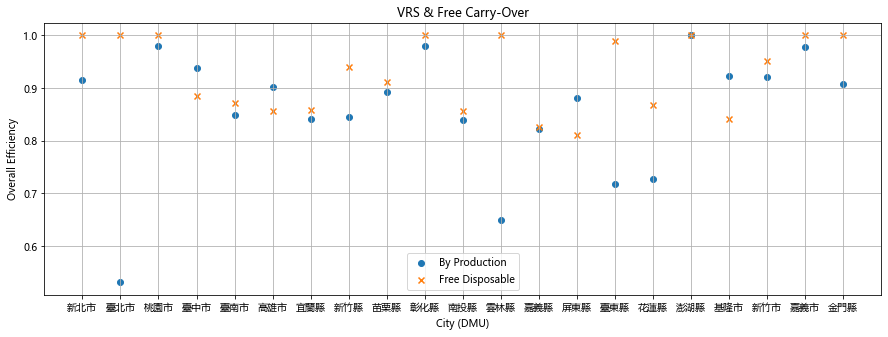

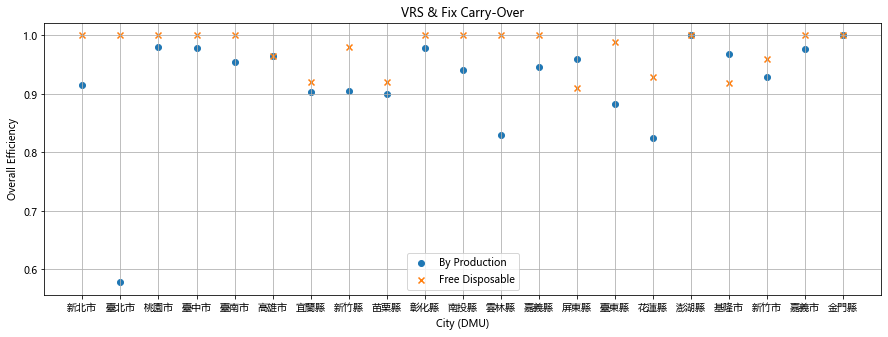

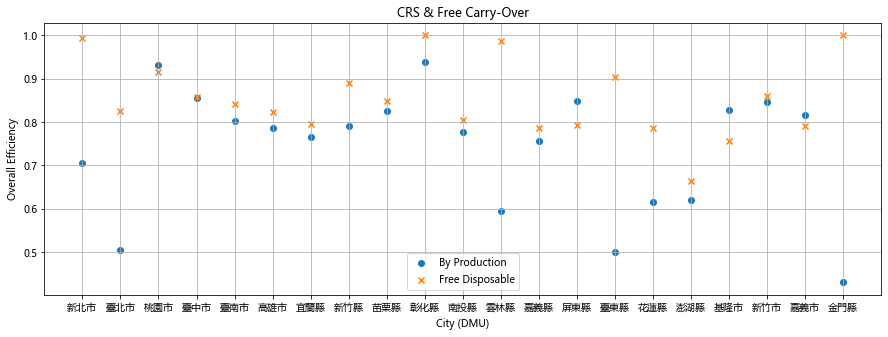

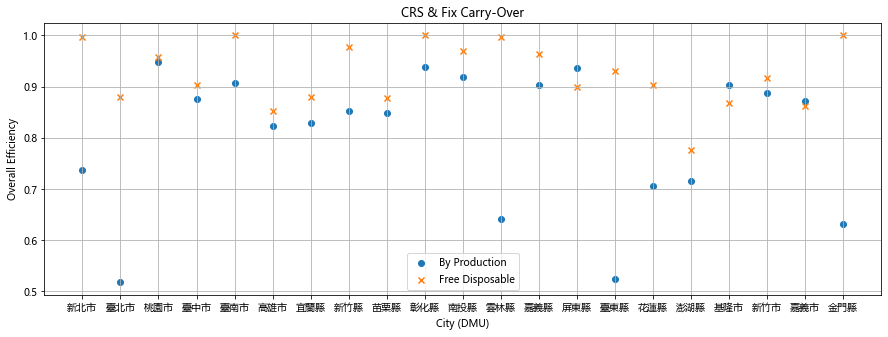

In [10]:
PlotsOverall(BP_D_SBM, D_SBM)

### -- Area Period Efficiency

In [11]:
def PlotsAreaPeriod(Year, bp_year_area, Type):
    plt.figure(figsize=(10,7))
    df = pd.DataFrame.from_dict(bp_year_area[Type])    
    plt.plot(Year, df, marker='o')
    plt.title('Average Period Efficiency for each Area using Dynamic SBM with By-production')
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 使用中文字體
    plt.grid(True)
    plt.xlabel('Year')
    plt.ylabel('Period Efficiency')
    plt.legend(['北部', '中部', '南部', '東部', '離島']) 
    plt.show()

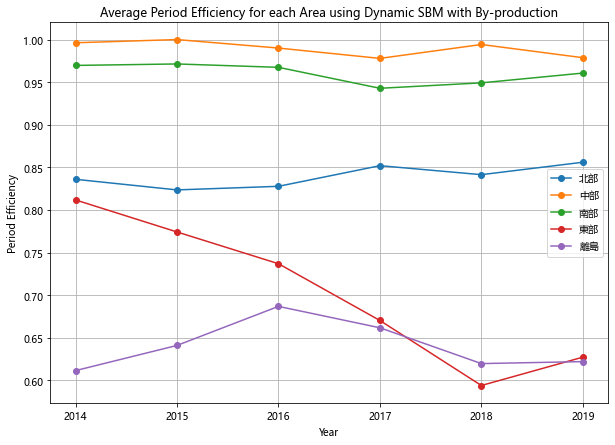

In [12]:
PlotsAreaPeriod(Year, bp_year_area, 'bp_CRS_free')

### -- Period Efficiency

In [13]:
def PlotsPeriod(Year, bp_year, no_year, Type):
    for firm in K:
        plt.plot(Year, bp_year['bp_%s'%(Type)][firm], marker='o')
        plt.plot(Year, no_year[Type][firm], marker='x')
        plt.title(firm)
        plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 使用中文字體
        plt.grid(True)
        plt.xlabel('Year')
        plt.ylabel('Period Efficiency')
        plt.legend(['By Production','Free Disposable']) 
        plt.show()

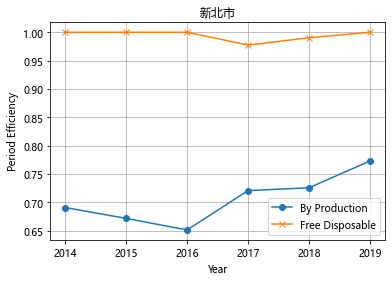

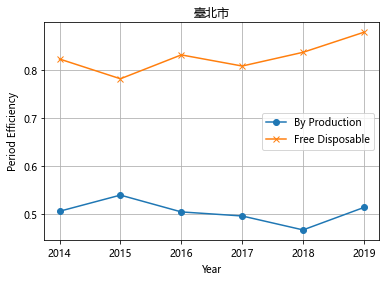

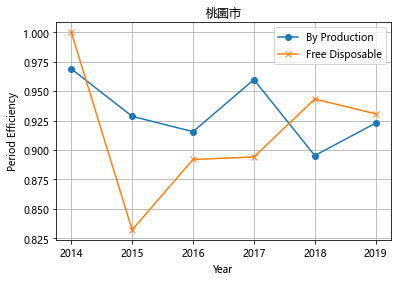

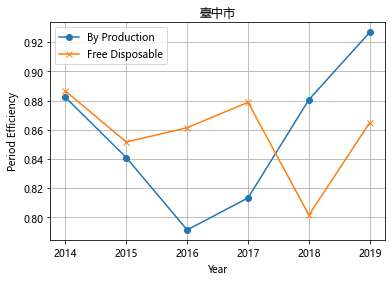

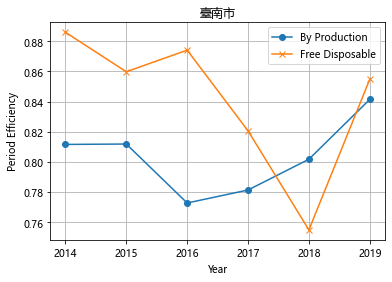

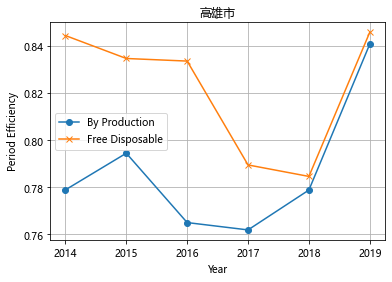

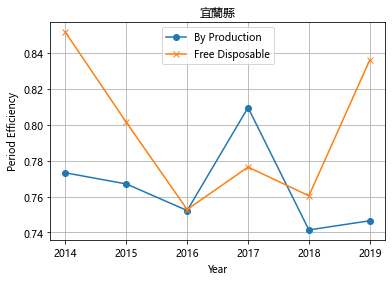

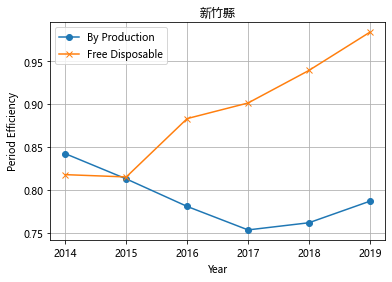

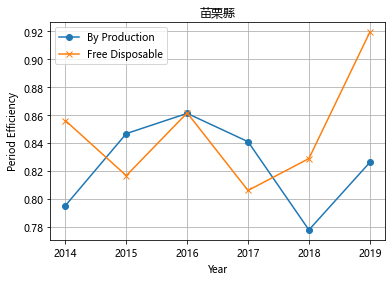

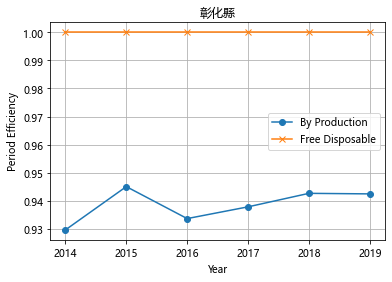

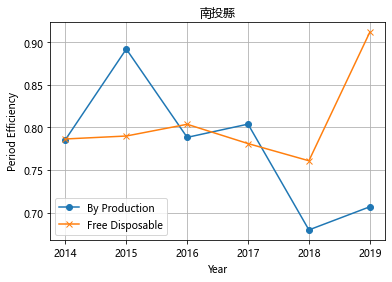

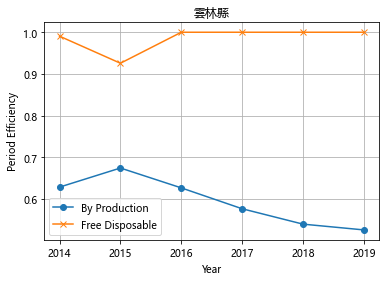

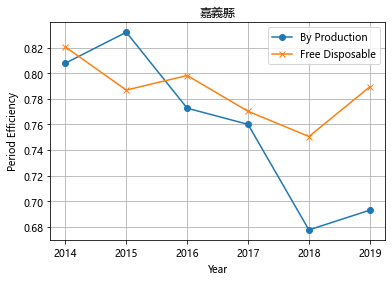

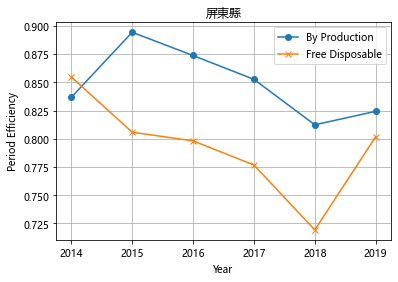

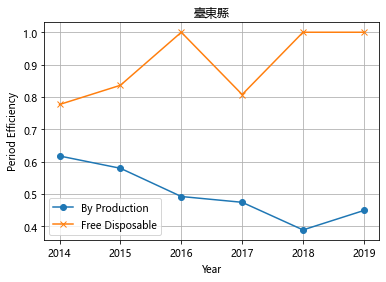

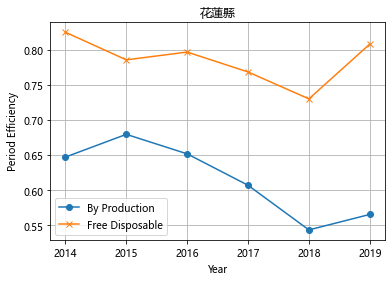

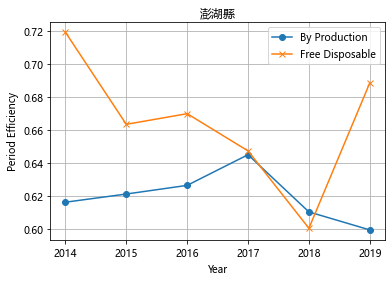

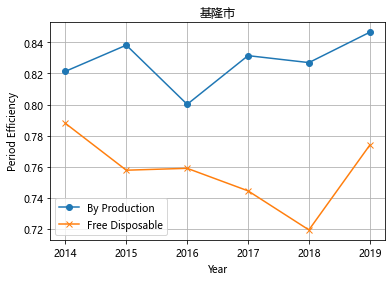

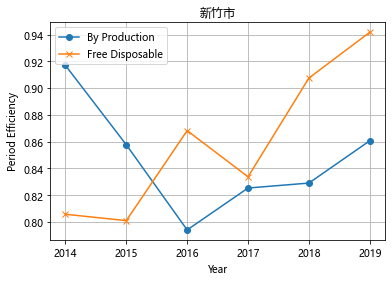

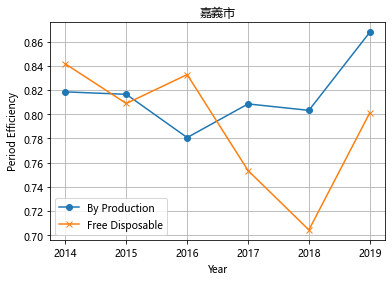

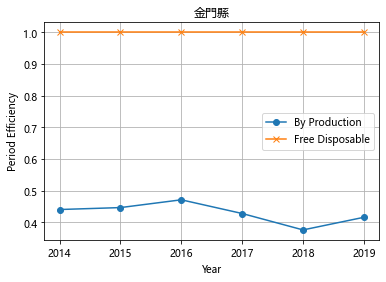

In [14]:
PlotsPeriod(Year, bp_year, no_year, 'CRS_free')